In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

In [3]:
def convert2cls(chir, csp_category): 
    if csp_category == '1': 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2': 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

## ChirBase

In [4]:
suppl = Chem.SDMolSupplier("../data/ChirBase/chirbase_clean.sdf")
mols = [x for x in suppl if x is not None]

In [5]:
df_dict = {'SMILES': [], 'isomer_SMILES': [], 'MB': [], 'CSP_category': [], 'K2/K1': [], 'Y': []}

for mol in mols: 
    if mol.HasProp('csp_no'):
        mb = mol.GetProp('csp_no')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    smiles_iso = Chem.CanonSmiles(Chem.MolToSmiles(mol))
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['isomer_SMILES'].append(smiles_iso)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['CSP_category'].append(mol.GetProp('mobile_phase_category'))
    df_dict['Y'].append(y)

df = pd.DataFrame.from_dict(df_dict)

In [6]:
df['MB'] = df['MB'].astype(int)
MB_dict = {91423: 'Chiralpak IB', 91119: 'Chirobiotic TAG', 90879: 'Chirobiotic T', 90704: 'Chirobiotic V', 90589: 'Whelk-O', 
           90357: 'Cyclobond I RN', 90246: 'Chiralcel OJ (Lux Cellulose-3)', 90211: 'Pirkle (R or S)-DNBPG', 
           45173: 'Chiralcel OD (Lux Cellulose-1)', 45167: 'Chiralpak AS', 44869: 'Chiralcel OB',
           23735: 'Chiralpak AD', 15723: 'Chirobiotic R', 394: 'Chiral-AGP', 91518: 'Chiralpak IC (Sepapak 5)', 
           2: 'Cyclobond I', 45172: 'Chiralpak IA', 3575: 'Ultron-ES-OVM',}
df['Column'] = df['MB'].apply(lambda x: MB_dict[x])

In [7]:
df

,SMILES,isomer_SMILES,MB,CSP_category,K2/K1,Y,Column
0,CCC(=O)OC(C)c1ccccc1,CCC(=O)O[C@@H](C)c1ccccc1,2,1,1.0100,0,Cyclobond I
1,CC(=O)OC(C)c1ccccc1,CC(=O)O[C@@H](C)c1ccccc1,2,1,1.0300,0,Cyclobond I
2,O=C(O)C(Cl)c1ccccc1,O=C(O)[C@@H](Cl)c1ccccc1,2,1,1.0300,0,Cyclobond I
3,CCCC(C(N)=O)c1ccc(O)c(O)c1,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,2,1,1.3100,2,Cyclobond I
4,COc1ccccc1C(C)O,COc1ccccc1[C@H](C)O,2,1,1.0400,0,Cyclobond I
...,...,...,...,...,...,...,...
76790,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,45173,2,1.1843,2,Chiralcel OD (Lux Cellulose-1)
76791,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,23735,2,1.8069,2,Chiralpak AD
76792,CCCS(=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,45172,1,2.1600,3,Chiralpak IA
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)CC1c1ccccc1,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,90246,2,5.0000,3,Chiralcel OJ (Lux Cellulose-3)


## CMRT

In [8]:
df_rt = pd.read_csv('../data/CMRT/cmrt_all_column.csv', index_col=0)

df_rt['isomer_SMILES'] = df_rt['SMILES'].apply(lambda x: Chem.CanonSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(x), 
                                                                                    isomericSmiles=True)))
df_rt['SMILES'] = df_rt['SMILES'].apply(lambda x: Chem.CanonSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(x), 
                                                                                    isomericSmiles=False)))

# df_rt = df_rt.sort_values(['index', 'RT'], ascending=False)

df_rt = df_rt[df_rt['RT'] != 0]
df_rt = df_rt.groupby(['index']).filter(lambda x: len(x) == 2)

In [9]:
df_rt

,index,SMILES,RT,Speed,i-PrOH_proportion,Literature,Column,isomer_SMILES
0,0,COC(=O)N(C)C(Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,2.14,0.5,0.05,10.1039/C9SC04534A,OJ3,COC(=O)N(C)[C@H](Cc1ccccc1)B1OC(C)(C)C(C)(C)O1
1,0,COC(=O)N(C)C(Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,1.81,0.5,0.05,10.1039/C9SC04534A,OJ3,COC(=O)N(C)[C@@H](Cc1ccccc1)B1OC(C)(C)C(C)(C)O1
3,2,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,2.13,0.5,0.30,10.1039/C8QO01291A,IA,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1
4,2,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,2.30,0.5,0.30,10.1039/C8QO01291A,IA,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1
5,3,Fc1cccc(C2NCc3ccccc3-c3ccccc32)c1,2.00,0.5,0.20,10.1039/C8SC04482A,OD3,Fc1cccc([C@@H]2NCc3ccccc3-c3ccccc32)c1
...,...,...,...,...,...,...,...,...
25860,14142,COC(=O)C(Cc1ccc2ccccc2c1)OC(=O)c1ccccc1,98.30,1.0,0.15,10.1002/adsc.201800774,OJH,COC(=O)[C@H](Cc1ccc2ccccc2c1)OC(=O)c1ccccc1
25862,14144,COc1ccc2c(c1)C(C=Cc1ccccc1)(CO)C(=O)N2COCc1ccccc1,119.10,0.8,0.05,10.31635/ccschem.019.20190064,IC3,COc1ccc2c(c1)[C@](/C=C/c1ccccc1)(CO)C(=O)N2COC...
25863,14144,COc1ccc2c(c1)C(C=Cc1ccccc1)(CO)C(=O)N2COCc1ccccc1,98.90,0.8,0.05,10.31635/ccschem.019.20190064,IC3,COc1ccc2c(c1)[C@@](/C=C/c1ccccc1)(CO)C(=O)N2CO...
25864,14145,O=C1OC(OC(=O)C(c2ccccc2)c2ccccc2)c2cccc(F)c21,75.30,0.8,0.10,10.1002/anie.202012445,IC3,O=C1O[C@H](OC(=O)C(c2ccccc2)c2ccccc2)c2cccc(F)c21


In [10]:
df_rt_alpha = df_rt.groupby('index').apply(lambda x: (x['RT'].max() - 2.9) / (x['RT'].min() -2.9)).to_frame(name='K2/K1')
df_rt_alpha = df_rt_alpha.merge(df_rt[['index', 'SMILES', 'isomer_SMILES', 'Column', 'RT']], on='index', how='left')
# df_rt_alpha = df_rt_alpha[df_rt_alpha.duplicated()]

In [11]:
df_rt_alpha

,index,K2/K1,SMILES,isomer_SMILES,Column,RT
0,0,0.697248,COC(=O)N(C)C(Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,COC(=O)N(C)[C@H](Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,OJ3,2.14
1,0,0.697248,COC(=O)N(C)C(Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,COC(=O)N(C)[C@@H](Cc1ccccc1)B1OC(C)(C)C(C)(C)O1,OJ3,1.81
2,2,0.779221,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@@H](C)c2ccc(C(F)(F)F)cc2)cc1,IA,2.13
3,2,0.779221,Cc1ccc(S(=O)(=O)CC(C)c2ccc(C(F)(F)F)cc2)cc1,Cc1ccc(S(=O)(=O)C[C@H](C)c2ccc(C(F)(F)F)cc2)cc1,IA,2.30
4,3,0.666667,Fc1cccc(C2NCc3ccccc3-c3ccccc32)c1,Fc1cccc([C@@H]2NCc3ccccc3-c3ccccc32)c1,OD3,2.00
...,...,...,...,...,...,...
23433,14142,4.416667,COC(=O)C(Cc1ccc2ccccc2c1)OC(=O)c1ccccc1,COC(=O)[C@H](Cc1ccc2ccccc2c1)OC(=O)c1ccccc1,OJH,98.30
23434,14144,1.210417,COc1ccc2c(c1)C(C=Cc1ccccc1)(CO)C(=O)N2COCc1ccccc1,COc1ccc2c(c1)[C@](/C=C/c1ccccc1)(CO)C(=O)N2COC...,IC3,119.10
23435,14144,1.210417,COc1ccc2c(c1)C(C=Cc1ccccc1)(CO)C(=O)N2COCc1ccccc1,COc1ccc2c(c1)[C@@](/C=C/c1ccccc1)(CO)C(=O)N2CO...,IC3,98.90
23436,14145,1.335635,O=C1OC(OC(=O)C(c2ccccc2)c2ccccc2)c2cccc(F)c21,O=C1O[C@H](OC(=O)C(c2ccccc2)c2ccccc2)c2cccc(F)c21,IC3,75.30


## Compare

In [12]:
set(df_rt_alpha['Column'].tolist())

{'AD',
 'AD3',
 'ADH',
 'AS',
 'ASH',
 'AZ',
 'IA',
 'IAH',
 'IAU',
 'IB',
 'IC',
 'IC3',
 'ICH',
 'ID',
 'IE',
 'IF',
 'IF3',
 'IG',
 'OD',
 'OD3',
 'ODH',
 'OJ',
 'OJ3',
 'OJH',
 'OZ3'}

In [13]:
set(df['Column'].tolist())

{'Chiral-AGP',
 'Chiralcel OB',
 'Chiralcel OD (Lux Cellulose-1)',
 'Chiralcel OJ (Lux Cellulose-3)',
 'Chiralpak AD',
 'Chiralpak AS',
 'Chiralpak IA',
 'Chiralpak IB',
 'Chiralpak IC (Sepapak 5)',
 'Chirobiotic R',
 'Chirobiotic T',
 'Chirobiotic TAG',
 'Chirobiotic V',
 'Cyclobond I',
 'Cyclobond I RN',
 'Pirkle (R or S)-DNBPG',
 'Ultron-ES-OVM',
 'Whelk-O'}

In [14]:
Col_map = {'Chiralcel OD (Lux Cellulose-1)': 'OD',
          'Chiralcel OJ (Lux Cellulose-3)': 'OJ', 
          'Chiralpak AD': 'AD',
          'Chiralpak AS': 'AS',
          'Chiralpak IA': 'IA',
          'Chiralpak IB': 'IB',
          'Chiralpak IC (Sepapak 5)': 'IC',}

df['Column_map'] = df['Column'].apply(lambda x: Col_map[x] if x in Col_map.keys() else np.nan)

In [15]:
df

,SMILES,isomer_SMILES,MB,CSP_category,K2/K1,Y,Column,Column_map
0,CCC(=O)OC(C)c1ccccc1,CCC(=O)O[C@@H](C)c1ccccc1,2,1,1.0100,0,Cyclobond I,NaN
1,CC(=O)OC(C)c1ccccc1,CC(=O)O[C@@H](C)c1ccccc1,2,1,1.0300,0,Cyclobond I,NaN
2,O=C(O)C(Cl)c1ccccc1,O=C(O)[C@@H](Cl)c1ccccc1,2,1,1.0300,0,Cyclobond I,NaN
3,CCCC(C(N)=O)c1ccc(O)c(O)c1,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,2,1,1.3100,2,Cyclobond I,NaN
4,COc1ccccc1C(C)O,COc1ccccc1[C@H](C)O,2,1,1.0400,0,Cyclobond I,NaN
...,...,...,...,...,...,...,...,...
76790,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,45173,2,1.1843,2,Chiralcel OD (Lux Cellulose-1),OD
76791,CCOc1ccccc1OCCNC(C)Cc1ccc(OC)c(S(N)(=O)=O)c1,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,23735,2,1.8069,2,Chiralpak AD,AD
76792,CCCS(=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,45172,1,2.1600,3,Chiralpak IA,IA
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)CC1c1ccccc1,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,90246,2,5.0000,3,Chiralcel OJ (Lux Cellulose-3),OJ


In [16]:
df_all = df_rt_alpha[['SMILES', 'Column', 'K2/K1']].merge(df[['SMILES', 'Column', 'K2/K1', 'Column_map', 'CSP_category']], 
                           left_on=['Column', 'SMILES'], 
                           right_on=['Column_map', 'SMILES'], how='inner')

Find the rule for choosing configuration in ChirBase? 

In [17]:
def chiral_tag(s): 
    mol = Chem.MolFromSmiles(s)
    for atom in mol.GetAtoms():
        if str(atom.GetChiralTag()) == 'CHI_TETRAHEDRAL_CCW':
            return 'S'
        elif str(atom.GetChiralTag()) == 'CHI_TETRAHEDRAL_CW':
            return 'R'
    return np.nan 

def config_compare(chosen_s, posible_s, rts): 
    assert len(chosen_s) == len(posible_s) == len(rts) == 2 
    if chosen_s[0] == posible_s[0]:
        if rts[0] > rts[1]:
            return 'High'
        elif rts[0] == rts[1]:
            return 'Same'
        else:
            return 'Low'
    elif chosen_s[0] == posible_s[1]:
        if rts[0] < rts[1]: 
            return 'High'
        elif rts[0] == rts[1]:
            return 'Same'
        else:
            return 'Low'
    else:
        return np.nan

df_all_tmp = df_rt_alpha[['SMILES', 'isomer_SMILES', 'Column', 'K2/K1', 'RT']].merge(df[['SMILES', 'isomer_SMILES', 'Column', 'K2/K1', 'Column_map', 'CSP_category']], 
                           left_on=['Column', 'SMILES'], 
                           right_on=['Column_map', 'SMILES'], how='inner')
df_all_tmp = df_all_tmp.groupby('SMILES').filter(lambda x: len(x)==2).reset_index(drop=True)
df_all_config = df_all_tmp.groupby('SMILES').apply(lambda x: config_compare(x['isomer_SMILES_y'].tolist(), 
                                                                       x['isomer_SMILES_x'].tolist(), 
                                                                       x['RT'].tolist())).to_frame(name='config_choice')
df_all_chiral_tag = df_all_tmp['isomer_SMILES_y'].apply(lambda x: chiral_tag(x)).to_frame(name='chiral_tag')

df_all_tmp = df_all_tmp.merge(df_all_config, 
                              on='SMILES', 
                              how='left').merge(df_all_chiral_tag, 
                                                left_index=True, 
                                                right_index=True, 
                                                how='left')

# df_all_tmp.to_csv('./chirbase_configuration_choice.csv', sep='\t', index=False)

In [18]:
high_rate = len(df_all_tmp[df_all_tmp['config_choice'] == 'High']) / len(df_all_tmp)
low_rate = len(df_all_tmp[df_all_tmp['config_choice'] == 'Low']) / len(df_all_tmp)

print('{:.2f}% configurations have higher retention times'.format(high_rate*100))
print('{:.2f}% configurations have lower retention times'.format(low_rate*100))

83.10% configurations have higher retention times
15.49% configurations have lower retention times


In [19]:
df_all['Y_x'] = df_all.apply(lambda x: convert2cls(x['K2/K1_x'], x['CSP_category']), axis=1)
df_all['Y_y'] = df_all.apply(lambda x: convert2cls(x['K2/K1_y'], x['CSP_category']), axis=1)

df_all['Y_x2'] = df_all['Y_x'].apply(lambda x: 0 if x == 0 or x == 1 else 1)
df_all['Y_y2'] = df_all['Y_y'].apply(lambda x: 0 if x == 0 or x == 1 else 1)

In [20]:
df_all

,SMILES,Column_x,K2/K1_x,Column_y,K2/K1_y,Column_map,CSP_category,Y_x,Y_y,Y_x2,Y_y2
0,CCOC(=O)C(CNC(C)=O)(Sc1ccc(C)cc1)c1ccccc1,OD,1.308036,Chiralcel OD (Lux Cellulose-1),1.3092,OD,2,2,2,1,1
1,CCOC(=O)C(CNC(C)=O)(Sc1ccc(C)cc1)c1ccccc1,OD,1.308036,Chiralcel OD (Lux Cellulose-1),1.3092,OD,2,2,2,1,1
2,CCOC(=O)C(C[N+](=O)[O-])(Sc1ccc(C(C)(C)C)cc1)c...,AS,1.259358,Chiralpak AS,1.2599,AS,2,2,2,1,1
3,CCOC(=O)C(C[N+](=O)[O-])(Sc1ccc(C(C)(C)C)cc1)c...,AS,1.259358,Chiralpak AS,1.2599,AS,2,2,2,1,1
4,CCOC(=O)C(C[N+](=O)[O-])(Sc1cc(C)cc(C)c1)c1ccccc1,AD,1.084337,Chiralpak AD,1.0845,AD,2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
255,C=CCC(O)COCc1ccccc1,AS,1.254545,Chiralpak AS,1.2800,AS,2,2,2,1,1
256,C=CCC(O)COCc1ccccc1,AS,1.254545,Chiralpak AS,1.1732,AS,2,2,2,1,1
257,C=CCC(O)COCc1ccccc1,AS,1.254545,Chiralpak AS,1.2800,AS,2,2,2,1,1
258,CCCCC=CC1(C)NS(=O)(=O)c2ccccc21,AD,1.254545,Chiralpak AD,1.2150,AD,2,2,2,1,1


In [21]:
df_all.to_csv('../data/compare_chirbase_cmrt.csv', index=False)
print('Save the comparison results!')

Save the comparison results!


In [22]:
len(df_all[df_all['Y_x'] == df_all['Y_y']])

232

In [23]:
len(df_all[df_all['Y_x'] == df_all['Y_y']]) / len(df_all)

0.8923076923076924

In [24]:
len(df_all[df_all['Y_x2'] == df_all['Y_y2']])

248

In [25]:
len(df_all[df_all['Y_x2'] == df_all['Y_y2']]) / len(df_all)

0.9538461538461539

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


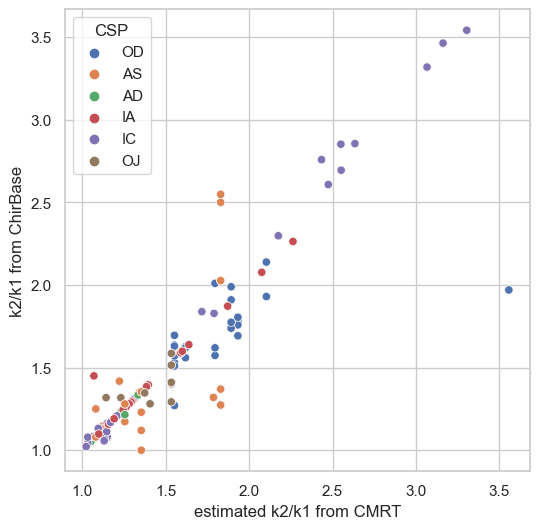

r2: 0.7732758183571495


In [26]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(data=df_all, x="K2/K1_x", y="K2/K1_y", hue="Column_x", ax=ax)

ax.set(xlabel='estimated k2/k1 from CMRT', ylabel='k2/k1 from ChirBase')
plt.legend(title='CSP')
plt.savefig('./compare_chirbase_cmrt.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./compare_chirbase_cmrt.png', dpi=600, bbox_inches='tight')
plt.show()

print('r2:', r2_score(df_all['K2/K1_x'], df_all['K2/K1_y']))

## Class distribution

In [27]:
chir_cnt = df.groupby(['Column', 'Y']).size().to_frame('Size').reset_index()



col = df[['Column', 'Column_map', 'CSP_category']].dropna().drop_duplicates()

cmrt_cnt = df_rt_alpha.merge(col, left_on='Column', right_on='Column_map')
cmrt_cnt['Y'] = cmrt_cnt[['K2/K1', 'CSP_category']].apply(lambda x: convert2cls(x['K2/K1'], x['CSP_category']), axis=1)

cmrt_cnt = cmrt_cnt.groupby(['Column_y', 'Y']).size().to_frame('Size').reset_index()
cmrt_cnt = cmrt_cnt.rename(columns={"Column_y": "Column"})

In [28]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [18, 7]})

# chir_cnt.pivot(index='Column', columns='Y', values='Size').plot(kind="bar", stacked=False,
#                                                                 logy=True, ax=axs[0])
# axs[0].legend(title='Class')
# cmrt_cnt.pivot(index='Column', columns='Y', values='Size').plot(kind="bar", stacked=False, 
#                                                                 logy=True, ax=axs[1])
# axs[1].legend(title='Class')

# fig.tight_layout()
# plt.show()

Calculate the percentage

In [29]:
cmrt_cnt_all = cmrt_cnt.groupby('Column')['Size'].sum().to_frame('Size_all').reset_index()
cmrt_cnt = cmrt_cnt.merge(cmrt_cnt_all, on='Column', how='left')
cmrt_cnt['Percentage'] = cmrt_cnt.apply(lambda x: x['Size']/x['Size_all'], axis=1)

chir_cnt_all = chir_cnt.groupby('Column')['Size'].sum().to_frame('Size_all').reset_index()
chir_cnt = chir_cnt.merge(chir_cnt_all, on='Column', how='left')
chir_cnt['Percentage'] = chir_cnt.apply(lambda x: x['Size']/x['Size_all'], axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


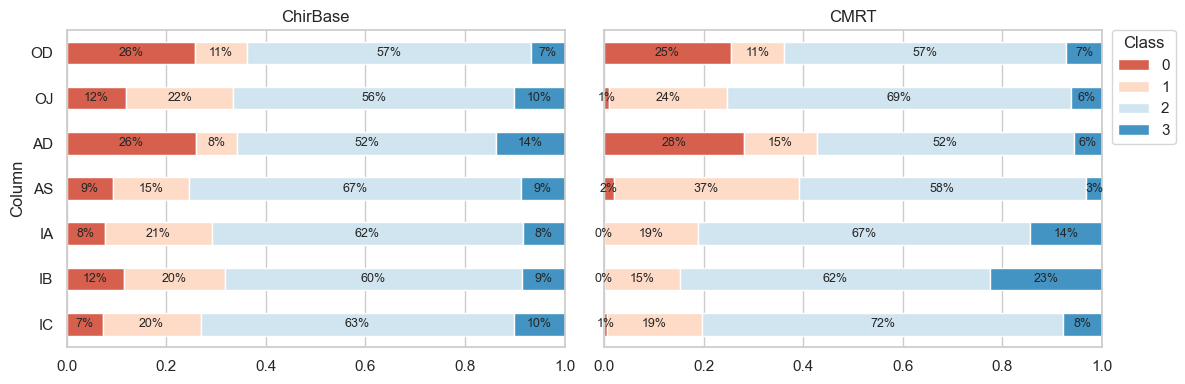

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
palette = sns.color_palette('RdBu', n_colors=4)

chir_cnt[chir_cnt['Column'].isin(cmrt_cnt['Column'])].pivot(index='Column', 
                                                            columns='Y', 
                                                            values='Percentage').plot(kind="barh", 
                                                                                      stacked=True, 
                                                                                      color=palette, 
                                                                                      ax=axs[0]).set(title='ChirBase')
axs[0].legend([],[], frameon=False)
axs[0].set_yticklabels(['IC', 'IB', 'IA', 'AS', 'AD', 'OJ', 'OD'])
for i in axs[0].containers:
    axs[0].bar_label(i, labels=[f'{x:.0%}' for x in i.datavalues], fontsize=9, label_type='center')
axs[0].set(xlim=(0,1))

cmrt_cnt.pivot(index='Column', 
               columns='Y', 
               values='Percentage').plot(kind="barh", 
                                         stacked=True, 
                                         color=palette, 
                                         ax=axs[1]).set(title='CMRT')
axs[1].legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
axs[1].set_yticklabels(['IC', 'IB', 'IA', 'AS', 'AD', 'OJ', 'OD'])
for i in axs[1].containers:
    axs[1].bar_label(i, labels=[f'{x:.0%}' for x in i.datavalues], fontsize=9, label_type='center')
axs[1].set(xlim=(0,1))

fig.tight_layout()
plt.savefig('./compare_chirbase_cmrt_class.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./compare_chirbase_cmrt_class.png', dpi=600, bbox_inches='tight')
plt.show()

## Extra

In [31]:
# from rdkit import Chem
# from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=False
# IPythonConsole.molSize = 300,300

In [32]:
# for s in df['SMILES'].tolist(): 
#     m = Chem.MolFromSmiles(s)
#     isomers = tuple(EnumerateStereoisomers(m))
#     if len(isomers) != 2: 
#         print('\n{} isomers are found!\n'.format(len(isomers)))

#         for smi in sorted(Chem.MolToSmiles(x, isomericSmiles=True) for x in isomers):
#             print(smi)